## Imporerer pakker

In [343]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, f1_score, log_loss, confusion_matrix

from sklearn.compose import TransformedTargetRegressor

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor


# Classification Models
from sklearn.linear_model import LogisticRegression, HuberRegressor, BayesianRidge, LassoLars, PassiveAggressiveRegressor, TheilSenRegressor, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Other Model Utilities
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
from sklearn import set_config
import plotly.express as px
from sklearn.compose import TransformedTargetRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from scipy import stats
from xgboost import XGBRegressor
from sklearn.preprocessing import TargetEncoder
import shap

## Laster inn filer

In [344]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

In [345]:
# Combine train and test data for processing
full_data = pd.concat([train_df, val_df, test_df], ignore_index=True)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

## Variabelutvinning

In [346]:

numeric_cols = [
        'alder', 'utdanning', 'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
        'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 'serumalbumin', 
        'bilirubin', 'kreatinin', 'natrium', 'blod_ph', 
        'antall_komorbiditeter', 'koma_score', 'fysiologisk_score', 
        'apache_fysiologisk_score', 'overlevelsesestimat_2mnd' ,'overlevelsesestimat_6mnd', 
        'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd', 'diabetes', 
        'glukose', 'blodurea_nitrogen', 'urinmengde','dødsfall' ,'sykehusdød',
        'demens'
    ]
categorical_cols = ['kjønn', 'etnisitet', 'sykdomskategori_id', 'sykdomskategori', 
                        'sykdom_underkategori', 'dnr_status',
                     'inntekt', 'kreft']

colsNotIncluded = set(train_df.columns) - set(numeric_cols) - set(categorical_cols)
print(colsNotIncluded)

{'adl_pasient', 'oppholdslengde', 'adl_stedfortreder'}


## Pipeline

In [347]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer())  # Placeholder for imputation
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_transformer = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numeric_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
])

# Define the final pipeline with a placeholder model
pipefinal = Pipeline(steps=[
    ('columntransformer', col_transformer),
    ('model', RandomForestRegressor(random_state=42))  # Placeholder model
])

In [348]:
def prepare_data(df, categorical_cols, numeric_cols):
    # Step 1: Handle ADL logic
    # Create 'adl' column by combining 'adl_pasient' and 'adl_stedfortreder'
    df['adl'] = df['adl_pasient'].combine_first(df['adl_stedfortreder'])

   # Step 2: Create the 'ADL_no' column where 'ADL' is NaN and 'oppholdslengde' is less than 7 days
    df['adl_no'] = df['adl'].isna() & (df['oppholdslengde'] < 7)

    # Drop the original 'adl_pasient' and 'adl_stedfortreder' columns
    df = df.drop(columns=['adl_pasient', 'adl_stedfortreder'])

    # Step 3: Create new severity level indicators based on 'fysiologisk_score'
    df['alvorlighetsgrad_høy'] = (df['fysiologisk_score'] > 60).astype(bool)
    df['alvorlighetsgrad_lav'] = (df['fysiologisk_score'] < 10).astype(bool)

    # Additional columns generated from transformations
    additional_cols = ['adl_no', 'alvorlighetsgrad_høy', 'alvorlighetsgrad_lav']

    # Separate target variable
    y = df['oppholdslengde'].values
    
    # Drop the target variable from the features
    X = df.drop(columns=['oppholdslengde']).copy()

    # Ensure all column names are strings to avoid issues with mixed types
    X.columns = X.columns.astype(str)

    # Convert the result back into a DataFrame with appropriate column names
    all_feature_names = numeric_cols + categorical_cols

    # Only keep numeric and categorical columns
    X_prepared = X[numeric_cols + categorical_cols]


    X_prepared = pd.DataFrame(X_prepared, columns=all_feature_names, index=X.index)

    X_prepared  = pd.concat([X_prepared, df[additional_cols]], axis=1)


    return X_prepared, y

In [349]:
X_train, y_train = prepare_data(train_df, categorical_cols, numeric_cols)
X_val, y_val = prepare_data(val_df, categorical_cols, numeric_cols)
X_test, y_test = prepare_data(test_df, categorical_cols, numeric_cols)

## Grunnlinjemodeller

In [350]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
prediction = baseline.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

21.59611100410102

In [351]:
baseline2 = DummyRegressor(strategy='median')
baseline2.fit(X_train, y_train)
prediction = baseline2.predict(X_val)
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline

22.712103715253104

## Modeller

In [352]:
param_grid = {
    'columntransformer__num_pipeline__impute': [
        SimpleImputer(strategy='mean'),
        SimpleImputer(strategy='median'),
        KNNImputer(n_neighbors=5),
        KNNImputer(n_neighbors=20),
        KNNImputer(n_neighbors=40)
    ],
    'columntransformer__cat_pipeline__impute': [
        SimpleImputer(strategy='most_frequent'),
        SimpleImputer(strategy='constant', fill_value=np.nan)
    ],
    'model': [
        RandomForestRegressor(n_estimators=200,max_depth=50, random_state=42),
        GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
        Ridge(alpha=1.0),
        Lasso(alpha=0.1),
        ElasticNet(alpha=0.1, l1_ratio=0.5),
        ExtraTreesRegressor(),
    ]
}


In [353]:
grid_search = GridSearchCV(pipefinal, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the pipeline
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.3f}")

# Use the best model to predict on the validation set
y_val_pred = best_model.predict(X_val)
rmse_val = root_mean_squared_error(y_val, y_val_pred)
print(f"RMSE on Validation Set: {rmse_val:.3f}")




Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=   8.7s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=   8.7s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=   8.7s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=Ridge(); total time=   0.1s
[CV] END columnt

In [354]:
# Adjust display settings for better visibility
pd.set_option('display.max_colwidth', None)  # Display full content of each cell
pd.set_option('display.max_columns', None)   # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping of columns
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Since the scores are negative (because we used neg_root_mean_squared_error), convert them to positive RMSE values
cv_results_df['mean_test_score'] = -cv_results_df['mean_test_score']

# Sort by mean_test_score to get the best RMSE values in ascending order (lower is better for RMSE)
top_5_models = cv_results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=True).head(10)

# Ensure it's a DataFrame and display the top 5 models with their parameters and RMSE
print(top_5_models)

                                                                                                                                                                                                          params  mean_test_score
47                      {'columntransformer__cat_pipeline__impute': SimpleImputer(fill_value=nan, strategy='constant'), 'columntransformer__num_pipeline__impute': KNNImputer(), 'model': ExtraTreesRegressor()}        19.554598
59        {'columntransformer__cat_pipeline__impute': SimpleImputer(fill_value=nan, strategy='constant'), 'columntransformer__num_pipeline__impute': KNNImputer(n_neighbors=40), 'model': ExtraTreesRegressor()}        19.584764
35                   {'columntransformer__cat_pipeline__impute': SimpleImputer(fill_value=nan, strategy='constant'), 'columntransformer__num_pipeline__impute': SimpleImputer(), 'model': ExtraTreesRegressor()}        19.589364
53        {'columntransformer__cat_pipeline__impute': SimpleImputer(fill_value=nan, strategy='co

In [355]:
# Extract the model from the pipeline
best_model = grid_search.best_estimator_.named_steps['model']

# Check if the model has the 'feature_importances_' attribute
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    importances = best_model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,  # Ensure these columns match the ones after transformation
        'Importance': importances
    })

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the most important features
    print(feature_importance_df)
else:
    print("The selected model does not have feature importances.")

ValueError: All arrays must be of the same length

In [322]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer())  # Placeholder for imputation
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot-encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_transformer = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, numeric_cols),
    ('cat_pipeline', cat_pipeline, categorical_cols)
])

pipefinal_ridge = Pipeline(steps=[
    ('columntransformer', col_transformer),
    ('model', Ridge())  # Ridge regression as the model
])

# Define the parameter grid for Ridge (only alpha)
param_grid_ridge = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Tuning the alpha parameter
}

# Set up GridSearchCV for Ridge
grid_search_ridge = GridSearchCV(pipefinal_ridge, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the Ridge model using GridSearchCV
grid_search_ridge.fit(X_train, y_train)

# Get the best model and its parameters
best_ridge_model = grid_search_ridge.best_estimator_
print(f"Best alpha: {grid_search_ridge.best_params_}")
print(f"Best RMSE: {-grid_search_ridge.best_score_:.3f}")

# Use the best model to predict on the validation set
y_val_pred = best_ridge_model.predict(X_val)
rmse_val = np.sqrt(((y_val_pred - y_val) ** 2).mean())
print(f"RMSE on Validation Set: {rmse_val:.3f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .................................model__alpha=0.001; total time=   0.0s
[CV] END .................................model__alpha=0.001; total time=   0.1s
[CV] END .................................model__alpha=0.001; total time=   0.1s
[CV] END .................................model__alpha=0.001; total time=   0.1s
[CV] END .................................model__alpha=0.001; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.2s
[CV] END ...................................model__alpha=0.1; total time=   0.2s
[CV] END ...................................model

In [301]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    fig = px.scatter(df, x='Actual', y='Predicted', title=f"{model_name}: Actual vs. Predicted")
    fig.add_shape(type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
                  x1=df['Actual'].max(), y1=df['Actual'].max(), line=dict(color='Red', dash='dash'))
    fig.show()

# Assuming y_val_pred is a 1D array of predictions
plot_actual_vs_pred(y_val, y_val_pred, "Random Forest with Target Encoding")

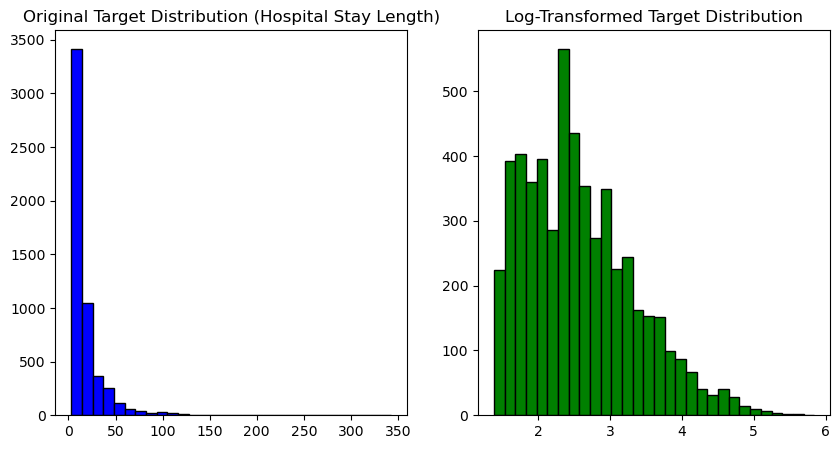

In [302]:
plt.figure(figsize=(10, 5))

# Histogram of original target values
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, color='blue', edgecolor='black')
plt.title('Original Target Distribution (Hospital Stay Length)')

# Histogram of log-transformed target values
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y_train), bins=30, color='green', edgecolor='black')
plt.title('Log-Transformed Target Distribution')

plt.show()

In [303]:
# Square root transformation
y_train_sqrt = np.sqrt(y_train)
y_val_sqrt = np.sqrt(y_val)

best_model.fit(X_train, y_train_sqrt)
pred_sqrt = best_model.predict(X_val)

# Inverse transformation (squaring the predictions)
pred_original_scale = np.square(pred_sqrt)

# Calculate RMSE
rmse = root_mean_squared_error(y_val, pred_original_scale)
print(f"RMSE with square root transformation: {rmse:.3f}")

# Plot actual vs predicted
plot_actual_vs_pred(y_val, pred_original_scale, "Random Forest with Square Root Transformation")

RMSE with square root transformation: 20.509


## Forsøker å trene modellen på ved å fjerne ekstreme uteliggere med over 95% 

In [263]:
threshold = np.percentile(y_train, 95)

# Filter out rows where the target is above the threshold
X_train_filtered = X_train[y_train < threshold]
y_train_filtered = y_train[y_train < threshold]

X_val_filtered = X_val[y_val < threshold]
y_val_filtered = y_val[y_val < threshold]


In [264]:
# Fit the pipeline without outliers
grid_search.fit(X_train_filtered, y_train_filtered)

# Get the best model and its parameters
best_model_filtered = grid_search.best_estimator_

# Predict on the filtered validation set
y_val_pred_filtered = best_model_filtered.predict(X_val_filtered)

# Calculate RMSE for the filtered data
rmse_val_filtered = root_mean_squared_error(y_val_pred_filtered, y_val_filtered) 
print(f"RMSE on Validation Set (without outliers): {rmse_val_filtered:.3f}")

# Plot actual vs predicted for filtered data
plot_actual_vs_pred(y_val_filtered, y_val_pred_filtered, "Model Without Outliers")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=  10.1s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=  10.2s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42); total time=  10.2s
[CV] END columntransformer__cat_pipeline__impute=SimpleImputer(strategy='most_frequent'), columntransformer__num_pipeline__impute=SimpleImputer(), model=Ridge(); total time=   0.1s
[CV] END columnt

KeyboardInterrupt: 

In [220]:
fig = px.histogram(y_train_filtered)
fig.show()

In [201]:
# Update pipeline to use Lasso regression model
pipe_lasso = Pipeline(steps=[
    ('columntransformer', col_transformer),
    ('model', Lasso(max_iter=10000, random_state=42))  # Placeholder for Lasso
])

# Define a parameter grid for Lasso
param_grid_lasso = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  # Values to search for regularization strength
}

# Set up grid search
grid_search_lasso = GridSearchCV(pipe_lasso, param_grid_lasso, cv=5, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search_lasso.fit(X_train_filtered, y_train_filtered)

# Get the best model and its parameters
best_lasso_model = grid_search_lasso.best_estimator_
print(f"Best Parameters for Lasso: {grid_search_lasso.best_params_}")
print(f"Best RMSE for Lasso: {-grid_search_lasso.best_score_:.3f}")

# Use the best Lasso model to predict on the validation set
y_val_pred_lasso = best_lasso_model.predict(X_val_filtered)
rmse_val_lasso = root_mean_squared_error(y_val_filtered, y_val_pred_lasso)
print(f"RMSE on Validation Set (Lasso): {rmse_val_lasso:.3f}")

# Plot actual vs predicted for filtered data
plot_actual_vs_pred(y_val_filtered, y_val_pred_lasso, "Model Without Outliers")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................model__alpha=0.01; total time=   0.2s
[CV] END ..................................model__alpha=0.01; total time=   0.2s
[CV] END ..................................model__alpha=0.01; total time=   0.2s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END ...................................model__alpha=0.1; total time=   0.1s
[CV] END ..................................model__alpha=0.01; total time=   0.1s
[CV] END .................................model__alpha=0.001; total time=   0.4s
[CV] END .................................model__alpha=0.001; total time=   0.5s
[CV] END .................................model__alpha=0.001; total time=   0.4s
[CV] END ...................................model__alpha=0.1; total time=   0.1s
[CV] END .................................model__alpha=0.001; total time=   0.5s
[CV] END ...................................model

In [203]:
# Update the pipeline to use Linear Regression
pipe_linear = Pipeline(steps=[
    ('columntransformer', col_transformer),
    ('model', LinearRegression())
])

# Train the linear regression model
pipe_linear.fit(X_train_filtered, y_train_filtered)

# Use the linear regression model to predict on the validation set
y_val_pred_linear = pipe_linear.predict(X_val_filtered)

# Calculate RMSE for the validation set
rmse_val_linear = root_mean_squared_error(y_val_pred_linear, y_val_filtered) 
print(f"RMSE on Validation Set (Linear Regression): {rmse_val_linear:.3f}")
# Plot actual vs predicted for filtered data
plot_actual_vs_pred(y_val_filtered, y_val_pred_linear, "Model Without Outliers")

RMSE on Validation Set (Linear Regression): 9.646


## TODO: Fortsette å teste med flere variable, eventuelt forsøke å fjerne noen. Analysere RMSE, for å finne ut hvorfor den er som den er. Er det mulig at modellen er god, men at den misser stort på uteliggere?